## A simple scheduling problem (based on the exercise 2 done in class)

Here is a very simple static scheduling problem.
We consider a set $J$ tasks ($T_1, T_2, \cdots, T_{J}$), each requiring a fixed amount of CPU (task $T_j$ requirement is noted $c_j$).
A maximum of $M$ machines are available, for now each of them having the same CPU capacity (let say $1$ CPU unit).
For now, we do not consider other resources (RAM, disk, network...).

We want to find a solution (scheduling) which minimizes the amount of machines powered on in order to execute all the task while fullfilling their CPU needs.
This problem is basically a [bin packing problem](https://en.wikipedia.org/wiki/Bin_packing_problem).

Its formulation is not possible in *pure* Linear Programming, as it requires some binary decision variable (becoming [Mixed Integer Linear Programming](https://en.wikipedia.org/wiki/Integer_programming) or MILP).

### Input of the problem

| Name      | Type    | Description                               |
|-----------|:--------|:-------------------------------------------|
| $c_j$     | real    | Amount of CPU required by task $T_j$       |
| $M$       | integer | Maximum machines available ($10$ here)     |
| $C$       | real    | CPU capacity of every machine ($1.0$ here) |

### Decision variables used

| Name      | Type   | Description                               |
|-----------|:-------|:------------------------------------------|
| $x_{m,j}$ | binary | 1 if task $j$ is scheduled on machine $m$ |
| $p_{m}$   | binary | 1 if the machine $m$ is powered-on        |

### Possible Mixed Integer Linear Program formulation

$$
\begin{align}
\text{Minimize: } & \sum_{m=1}^{M} p_i & \quad \\
\text{Subject to:} \quad & \forall{j \in [1, J]}, & \sum_{m=1}^{M} x_{m,j}  = 1 \\
& \forall{m \in [1, M]}, & \sum_{j=1}^{T} x_{m,j} \cdot c_j \leq 1 \\
& \forall{m \in [1, M]}, \forall{j \in [1, J]}, & p_m \geq x_{m,j} % alternative: \sum_{j=1}^{T} \frac{x_{i,j}}{T}
\end{align}
$$

### Note
If you found a different solution in class (different decision variables and constraints), feel free to experiment it in this practical session!


# Part 1 : Using PuLP and Python for a simple scheduling problem
## Question 1

Based on the MILP formulation, use PuLP to solve the following instance:
- $M=5$ machines, each with the same capacity $C=1.0$
- 6 tasks with the following requirements

|-   | T0 | T1 | T2 | T3 | T4 | T5 |
|----|----|----|----|----|----|----|
| CPU| 0.2| 0.5| 0.3| 0.6|0.67|0.25|

In [3]:
import pulp
import matplotlib.pyplot as plt

In [4]:
## ============================== CONSTANTS
# Machines
M = 5
C = 1.0

# Tasks
costs = [0.2, 0.5, 0.3, 0.6, 0.67, 0.25]
T = len(costs)


## ============================== DECISION VARIABLES
prob = pulp.LpProblem("simple_task_scheduling")

x = [[0] * T for i in range(M)]
p = [0] * M

for m in range(M):
    for j in range(T):
        x[m][j] = pulp.LpVariable('x'+str(m)+'_'+str(j), cat='Binary')

for m in range(M):
    p[m] = pulp.LpVariable('p'+str(m), cat='Binary')


## ============================== CONSTRAINTS
for j in range(T):
    prob += pulp.lpSum([x[m][j] for m in range(M)]) == 1
    
for m in range(M):
    prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= 1

for m in range(M):
    for j in range(T):
        prob += p[m] >= x[m][j]


## ============================== OBJECTIVE FUNCTION
prob.sense = pulp.LpMinimize
prob.setObjective(pulp.lpSum([p[m] for m in range(M)]))


## ============================== SOLVING
prob.solve()
pulp.LpStatus[prob.status]


## ============================== PRINTING
for v in prob.variables():
    print(v.name, '=', v.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/chuxclub/.local/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/ec354d1650534671bb358c3b1d31bc9e-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/ec354d1650534671bb358c3b1d31bc9e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 46 COLUMNS
At line 242 RHS
At line 284 BOUNDS
At line 320 ENDATA
Problem MODEL has 41 rows, 35 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 31 rows, 35 colum

## Question 2

To visualize the solution, transform the PuLP data in order to fit the requirements of the function `plot_online_schedule()` thereafter.
An example is given below.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [6]:
def plot_online_schedule(machines_info, tasks_info):
    """ Graphical representation of an online scheduling solutions.
    
    :param machines_info: information on each machine, as a list of dictionaries containing
                          at least the fields:
                          - 'capacity' (CPU capacity of this machine, float)
                          - 'poweron' (True if the machine is powered on)
    :param tasks_info: information on each task, as a list of dictionaries containing at least
                       the fields:
                       - 'machine': machine on which the task was scheduled, None if left unscheduled
                       - 'cpu': amount of CPU required by the task
    :return: the matplotlib figure and axe objects
    """
    nbtasks = len(tasks_info)
    nbmachines = len(machines_info)
    
    maxcapacity = max(mi['capacity'] for mi in machines_info)

    separator = 0.1

    fig, ax = plt.subplots(1, 1, figsize=(nbmachines, 4))
    ax.set_xlim(left=-separator, right=nbmachines+separator)
    ax.set_ylabel('CPU usage')
    ax.set_ylim(bottom=0, top=maxcapacity)

    # set some labels for each machine
    ax.set_xlabel('Machines')
    ax.set_xticks([m + 0.5 for m in range(nbmachines)])
    ax.set_xticklabels(['M{}'.format(m+1) for m in range(nbmachines)])


    for m in range(nbmachines):
        xbase = m + separator/2
        color = 'yellow' if machines_info[m]['poweron'] else 'lightgray'
        p1 = patches.Rectangle((xbase, 0), 1 - separator, machines_info[m]['capacity'], facecolor=color, edgecolor='black', linestyle='-')
        ax.add_patch(p1)

        curcpu = 0
        for t in range(nbtasks):
            if tasks_info[t]['machine'] == m:
                task_usage = tasks_info[t]['cpu']

                # display the task itself
                task_patch = patches.Rectangle((xbase, curcpu), 1 - separator, task_usage, facecolor='red', edgecolor='black', linestyle='-', linewidth=2)
                ax.add_patch(task_patch)

                # add a label for the task
                ax.text(xbase + (1 - separator)/2, curcpu + task_usage / 2, "T{}".format(t), weight='bold', horizontalalignment='center', verticalalignment='center')

                curcpu += task_usage
                
    return fig, ax

Example of usage, with 3 machines and 3 tasks:

(<Figure size 216x288 with 1 Axes>,
 <AxesSubplot:xlabel='Machines', ylabel='CPU usage'>)

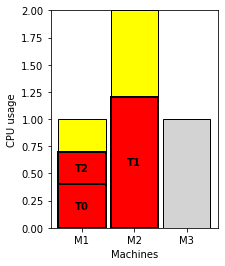

In [7]:
machines_info = [
    {'capacity': 1, 'poweron': True },
    {'capacity': 2, 'poweron': True },
    {'capacity': 1, 'poweron': False },
    ]

tasks_info = [
    {'cpu': 0.4, 'machine': 0},
    {'cpu': 1.2, 'machine': 1},
    {'cpu': 0.3, 'machine': 0},
    ]

plot_online_schedule(machines_info, tasks_info)

(<Figure size 360x288 with 1 Axes>,
 <AxesSubplot:xlabel='Machines', ylabel='CPU usage'>)

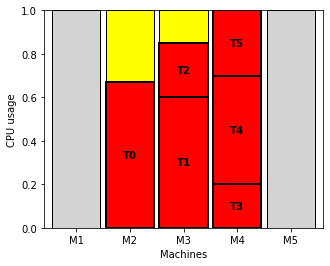

In [8]:
machines_info2 = [{'capacity': C, 'poweron': p[m].value()} for m in range(M)]

tasks_info2 = []
for m in range(M):
    for j in range(T):
        if(x[m][j].value() == 1):
            tasks_info2.append({'cpu': costs[j], 'machine': m})

plot_online_schedule(machines_info2, tasks_info2)

## Question 3

By using [Python's CSV module](https://docs.python.org/3/library/csv.html), write a function which:
- reads two files describing machine and tasks configuration
- create the PuLP model to solve the corresponding problem instance
- write the solution (if feasible) in two other files (one for the machines, the other for the tasks)

The function should have the following signature:
`find_optimal_schedule_basic(config_machines, config_tasks, output_machines, output_tasks)`

The format of each files is described thereafter, and is similar **but not identical** to the format used in the other practical session with J.M. Pierson.
A lot of fields are not used in the current model, you should ignore them for now in input files and write the string 'NA' in output files.

#### Input: machines configuration
```
# machine ID, CPU capacity, RAM (GB), Static power, Dynamic power, DVFS states
0, 1, 4, 40, 160, (0.5 - 0.8 - 1)
1, 2, 16, 60, 240, (1)
```

#### Input: tasks configuration
```
# task ID, arrival date, CPU requirement, RAM requirement (GB), deadline
0, 0, 0.2, 1, 10
1, 0, 0.5, 1.2, 4, 10
```

#### Output: machines state

```
# machine ID, time step, state, DVFS
0, 0, ON, 0.5
1, 0, OFF, 1
```

For now, time step is not used.
If the schedule was on multiple time steps, a row describing a given machine ID should be written for every time step.

The column `state` should contain either `ON`, `OFF`, `BOOTING` or `SHUTINGDOWN` (only the 2 first states are used for now).

#### Output: tasks state

```
# task ID, machine, schedule date
0, 0, 0
1, 0, 0
```

*Tips*: to test your read/write function, you can either create files in your Notebook directory and/or use the Python's [StringIO class](https://docs.python.org/3/library/io.html).
This last allows to perform file-like operation on string content, such as :

In [9]:
import io

with io.StringIO('config_machines.txt') as file:
    print(file.readline())

config_machines.txt


In [12]:
import csv


def loadConfig(fileName: str) -> [[str]]:
    with open(fileName, newline='') as f:
        res = []
        reader = csv.reader(f)
        for row in reader:
            res.append(row)
        res.pop(0)

    return res


def solveSchedulingPb(config_machines, config_tasks):
    ## ============================== CONSTANTS
    M = len(config_machines) # Nb machines
    C = float(config_machines[0][1]) # We take only one CPU capacity for all machines

    # Tasks
    costs = [float(i[2]) for i in config_tasks]
    T = len(costs)


    ## ============================== DECISION VARIABLES
    prob = pulp.LpProblem("simple_task_scheduling")

    x = [[0] * T for i in range(M)]
    p = [0] * M

    for m in range(M):
        for j in range(T):
            x[m][j] = pulp.LpVariable('x'+str(m)+'_'+str(j), cat='Binary')

    for m in range(M):
        p[m] = pulp.LpVariable('p'+str(m), cat='Binary')


    ## ============================== CONSTRAINTS
    for j in range(T):
        prob += pulp.lpSum([x[m][j] for m in range(M)]) == 1

    for m in range(M):
        prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= 1

    for m in range(M):
        for j in range(T):
            prob += p[m] >= x[m][j]


    ## ============================== OBJECTIVE FUNCTION
    prob.sense = pulp.LpMinimize
    prob.setObjective(pulp.lpSum([p[m] for m in range(M)]))


    ## ============================== SOLVING
    prob.solve()
    pulp.LpStatus[prob.status]


    ## ============================== PRINTING
    for v in prob.variables():
        print(v.name, '=', v.varValue)
        
    return (prob, x, p)


def getProbVar(pulpProb, varName: str):
    probVariables = pulpProb.variables()
    res = list(filter(lambda a : a.name == varName, probVariables))
    
    return res[0] if res != [] else res


def getSchedulingSolution(prob, x, configMachines, configTasks):
    machines_info = []
    tasks_info = []
    
    for i in range(len(configMachines)):
        p = getProbVar(prob, 'p'+str(i))
        f = getProbVar(prob, 'f'+str(i))
        machines_info.append({'ID': configMachines[i][0], 'time_step': 'NA', 
                              'state': 'ON' if p.value() == 1 else 'OFF', 
                              'DVFS': 'NA' if f == [] else f.value()})
    
    for m in range(len(configMachines)):
        for j in range(len(configTasks)):
            if(x[m][j].value() == 1):
                tasks_info.append({'ID': j, 'machine': m, 'schedule_date': 'NA'})
                
    return (machines_info, tasks_info)


def writeSolution(fileName, someDict, fieldNames):
    with open(fileName, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldNames)
        writer.writeheader()
        writer.writerows(someDict)

    
def find_optimal_schedule_basic(config_machines, config_tasks, output_machines, output_tasks):
    configMachines = loadConfig(config_machines)
    configTasks = loadConfig(config_tasks)
    
    (prob, x, p) = solveSchedulingPb(configMachines, configTasks)
    (machines_info, tasks_info) = getSchedulingSolution(prob, x, configMachines, configTasks)
    
    writeSolution(output_machines, machines_info, ['ID', 'time_step', 'state', 'DVFS'])
    writeSolution(output_tasks, tasks_info, ['ID', 'machine', 'schedule_date'])
    
    return prob
    
find_optimal_schedule_basic('config_machines.txt', 'config_tasks.txt', 'output_machines.txt', 'output_tasks.txt')
find_optimal_schedule_basic('config_machines2.txt', 'config_tasks2.txt', 'output_machines2.txt', 'output_tasks2.txt')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/chuxclub/.local/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/61da97cacf404c43ad5cbbae805076c9-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/61da97cacf404c43ad5cbbae805076c9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 46 COLUMNS
At line 242 RHS
At line 284 BOUNDS
At line 320 ENDATA
Problem MODEL has 41 rows, 35 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 31 rows, 35 colum

simple_task_scheduling:
MINIMIZE
1*p0 + 1*p1 + 0
SUBJECT TO
_C1: x0_0 + x1_0 = 1

_C2: x0_1 + x1_1 = 1

_C3: 0.2 x0_0 + 0.5 x0_1 <= 1

_C4: 0.2 x1_0 + 0.5 x1_1 <= 1

_C5: p0 - x0_0 >= 0

_C6: p0 - x0_1 >= 0

_C7: p1 - x1_0 >= 0

_C8: p1 - x1_1 >= 0

VARIABLES
0 <= p0 <= 1 Integer
0 <= p1 <= 1 Integer
0 <= x0_0 <= 1 Integer
0 <= x0_1 <= 1 Integer
0 <= x1_0 <= 1 Integer
0 <= x1_1 <= 1 Integer

#### Question 4 (optional)

##### 4.a) Solving time depending on number of tasks
By generating pseudo-random set of tasks, measure the execution time for solving instances of different sizes.
You can use either [time module](https://docs.python.org/3/library/time.html) or [timeit module](https://docs.python.org/3/library/timeit.html) for instance.
Makes sure it only takes into account feasible instances!

Does it look like what you expected given the potential complexity of MILP solving?
- if it does, can you estimate roughtly the time complexity (big O notation)?
- otherwise, what are possible explanations?

To visualize the results, you can use Matplotlib's pyplot (already imported here as `plt`) such as the following example:

Text(0, 0.5, 'Result')

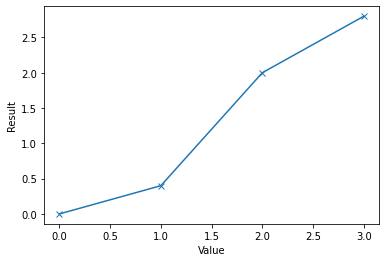

In [78]:
x = [0, 1, 2, 3]
y = [0, 0.4, 2, 2.8]

plt.plot(x, y, marker='x')
plt.xlabel('Value')
plt.ylabel('Result')

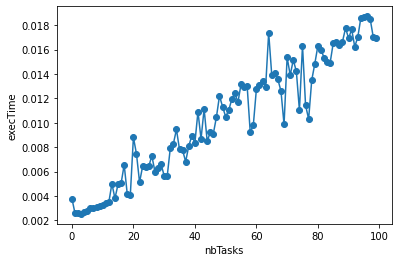

In [79]:
import random as rand
import time


def getRandShares(nbRandShares: int) -> float():
    res = []
    sumRes = 0
    
    for i in range(nbRandShares):
        res.append(rand.randint(1, 100))
        sumRes += res[i]
        
    return [(res[i] / sumRes) for i in range(nbRandShares)]


def getRandConfigTasks(nbTasks: int, totalCpuCapa: int) -> None:
    tasks = []
    randCosts = getRandShares(nbTasks)
    
    for i in range(nbTasks):
        tasks.append({'ID': i, 'arrival': 0, 'cost': randCosts[i], 'ram': 'NA', 'deadline': 'NA'})
    
    with open('randConfigTasks.txt', 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['ID', 'arrival', 'cost', 'ram', 'deadline'])
        writer.writeheader()
        writer.writerows(tasks)
        
    return 'randConfigTasks.txt'


def solveMuted(config_machines, config_tasks):
    ## ============================== CONSTANTS
    M = len(config_machines) # Nb machines
    C = float(config_machines[0][1]) # We take only one CPU capacity for all machines

    # Tasks
    costs = [float(i[2]) for i in config_tasks]
    T = len(costs)


    ## ============================== DECISION VARIABLES
    prob = pulp.LpProblem("simple_task_scheduling")

    x = [[0] * T for i in range(M)]
    p = [0] * M

    for m in range(M):
        for j in range(T):
            x[m][j] = pulp.LpVariable('x'+str(m)+'_'+str(j), cat='Binary')

    for m in range(M):
        p[m] = pulp.LpVariable('p'+str(m), cat='Binary')


    ## ============================== CONSTRAINTS
    for j in range(T):
        prob += pulp.lpSum([x[m][j] for m in range(M)]) == 1

    for m in range(M):
        prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= 1

    for m in range(M):
        for j in range(T):
            prob += p[m] >= x[m][j]


    ## ============================== OBJECTIVE FUNCTION
    prob.sense = pulp.LpMinimize
    prob.setObjective(pulp.lpSum([p[m] for m in range(M)]))


    ## ============================== SOLVING
    prob.solve(pulp.apis.PULP_CBC_CMD(msg=False))
    pulp.LpStatus[prob.status]


    ## ============================== PRINTING     
    return (prob, x, p)


def timedSolvedScheduling(config_machines, config_tasks):
    configMachines = loadConfig(config_machines)
    configTasks = loadConfig(config_tasks)
    
    timerStart = time.perf_counter()
    (prob, x, p) = solveMuted(configMachines, configTasks)
    timerStop = time.perf_counter()
    (machines_info, tasks_info) = getSchedulingSolution(prob, x, configMachines, configTasks)
    
    return timerStop - timerStart


def plotLpTasksComplexity(upperBound: int):
    nbTasks =  [i for i in range(upperBound)]
    execTime = [timedSolvedScheduling('config_machines2.txt', getRandConfigTasks(i, 3)) for i in range(upperBound)]

    plt.plot(nbTasks, execTime, marker='o')
    plt.xlabel('nbTasks')
    plt.ylabel('execTime')


plotLpTasksComplexity(100)

##### 4.b): Solving time depending on number of machines

Similar question, but now by studying the solving time for different number of machines.
In order to avoid the problem to be solved "trivially", it is important to have different capacity for the machines and enough tasks (of different requirements) to fill a large part of the machines.
Ideally, the total requirements of the tasks should be proportional to the total capacity of all the machines to ensure the problem is similarly difficult in all cases.

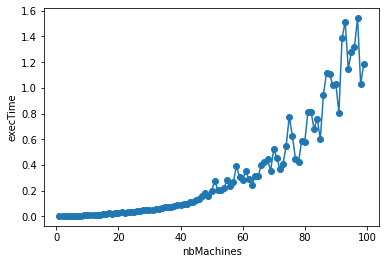

In [80]:
def getRandConfigMachines(nbMachines: int) -> None:
    machines = []
    
    for i in range(nbMachines):
        machines.append({'ID': i, 'cpu': 1.0, 'ram': 'NA', 'static': 'NA', 'dynamic': 'NA', 'dvfs': 'NA'})
    
    with open('randConfigMachines.txt', 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['ID', 'cpu', 'ram', 'static', 'dynamic', 'dvfs'])
        writer.writeheader()
        writer.writerows(machines)
        
    return 'randConfigMachines.txt'


def plotLpMachinesComplexity(upperBound: int):
    nbMachines =  [i for i in range(1, upperBound)]
    execTime = [timedSolvedScheduling(getRandConfigMachines(i), 
                                      getRandConfigTasks(i, i)) for i in range(1, upperBound)]

    plt.plot(nbMachines, execTime, marker='o')
    plt.xlabel('nbMachines')
    plt.ylabel('execTime')
    

plotLpMachinesComplexity(100)

## Part 2 : improving the considered model

We want to change the model to account power consumption of the machines and some simplified DVFS-like mechanism.
The first question (question 5) focus on the power consumption, the second (question 6) on the DVFS.

The **new objective** for these two questions is therefore to minimize the *power consumption* for scheduling all the tasks.
We can note that as *time* is not considered for now, minimizing power consumption is equivalent to minimizing *energy consumption*.


### Question 5: a power consumption model
We propose to use a simple static/dynamic power model, with only CPU utilization used for the dynamic part.

For each machine $m$, in addition to its capacity $C_m$, we have both static power consumption $S_m$ and dynamic part $D_m$.

The total consumption of a machine is $0 W$ if powered off, $S_m + (D_m * \frac{\mathit{CPU}_\mathit{used}}{C_m})$ otherwise.


After finding an appropriate MILP model for this problem, write the PuLP code to solve any instance of this problem given the input data (tasks and machines configuration).

In [20]:
def solveSchedulingPb(config_machines, config_tasks):
    ## ============================== CONSTANTS
    M = len(config_machines)                   # Nb machines
    C = [float(m[1]) for m in config_machines] # CPU capacity for each machine
    S = [float(m[3]) for m in config_machines] # Static power for each machine
    D = [float(m[4]) for m in config_machines] # Dynamic power for each machine

    # Tasks
    costs = [float(i[2]) for i in config_tasks] # CPU cost for each task
    T = len(costs)                              # Nb tasks


    ## ============================== DECISION VARIABLES
    prob = pulp.LpProblem("simple_task_scheduling")

    x = [[0] * T for i in range(M)]                      # Binary decision var: is task j on machine m?
    p = [0] * M                                          # Binary decision var: is machine m power on?
    c = [pulp.LpVariable("c"+str(m)) for m in range(M)]  # Float decision var: how much consumption for machine m ?
    
    for m in range(M):
        for j in range(T):
            x[m][j] = pulp.LpVariable('x'+str(m)+'_'+str(j), cat='Binary')

    for m in range(M):
        p[m] = pulp.LpVariable('p'+str(m), cat='Binary')

    
    ## ============================== CONSTRAINTS
    for j in range(T):
        prob += pulp.lpSum([x[m][j] for m in range(M)]) == 1

    for m in range(M):
        prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= C[m]

    for m in range(M):
        for j in range(T):
            prob += p[m] >= x[m][j]
    
    # NEW CONSTRAINT HERE (consumption for machine 'm' must be equal to what it consumes 
    # by being powered on and running tasks on it - cf. formula in statement above):
    for m in range(M):
        totalConsumption = lambda Pm, Sm, Dm, usedCPU, Cm: Pm * Sm + ((Dm * usedCPU) / Cm)
        usedCPU = pulp.lpSum([x[m][j] * costs[j] for j in range(T)])
        prob += c[m] == totalConsumption(p[m], S[m], D[m], usedCPU, C[m])


    ## ============================== OBJECTIVE FUNCTION
    prob.sense = pulp.LpMinimize
    prob.setObjective(pulp.lpSum(c))


    ## ============================== SOLVING
    prob.solve()
    pulp.LpStatus[prob.status]


    ## ============================== PRINTING
    for v in prob.variables():
        print(v.name, '=', v.varValue)
        
    return (prob, x, p)

    
find_optimal_schedule_basic('config_machines2.txt', 'config_tasks2.txt', 'output_machines2.txt', 'output_tasks2.txt')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/chuxclub/.local/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/4e67d4d3b4fd4964b00cf78bbccb6f98-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/4e67d4d3b4fd4964b00cf78bbccb6f98-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 54 RHS
At line 65 BOUNDS
At line 74 ENDATA
Problem MODEL has 10 rows, 8 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 144 - 0.00 seconds
Cgl0004I processed model has 4 rows, 4 columns (4 integer (4 of which binary)) and 8 elements
Cutoff increment increased from 1e-05 to 3.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 144
Cbc0038I Before mini branch and bound, 4 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not i

simple_task_scheduling:
MINIMIZE
1*c0 + 1*c1 + 0
SUBJECT TO
_C1: x0_0 + x1_0 = 1

_C2: x0_1 + x1_1 = 1

_C3: 0.2 x0_0 + 0.5 x0_1 <= 1

_C4: 0.2 x1_0 + 0.5 x1_1 <= 2

_C5: p0 - x0_0 >= 0

_C6: p0 - x0_1 >= 0

_C7: p1 - x1_0 >= 0

_C8: p1 - x1_1 >= 0

_C9: c0 - 40 p0 - 32 x0_0 - 80 x0_1 = 0

_C10: c1 - 60 p1 - 24 x1_0 - 60 x1_1 = 0

VARIABLES
c0 free Continuous
c1 free Continuous
0 <= p0 <= 1 Integer
0 <= p1 <= 1 Integer
0 <= x0_0 <= 1 Integer
0 <= x0_1 <= 1 Integer
0 <= x1_0 <= 1 Integer
0 <= x1_1 <= 1 Integer

### Question 6: simple DVFS with two states
We focus here on improving the performance/consumption model by introducing a simple mechanism, similar to DVFS in some aspects.

Instead of having a single state (performances $C_m$ and dynamic consumption $D_m$), each machine now have two working states:
- minimum performances, with CPU capacity $C_m^{\mathit{min}}$ and dynamic consumption $D_m^{\mathit{min}}$
- maximum performances, with CPU capacity $C_m^{\mathit{max}}$ and dynamic consumption $D_m^{\mathit{max}}$

The static consumption is not affected by the chosen state (always $S_m$).

*Note: we assume to have $C_m^{\mathit{max}} > C_m^{\mathit{min}}$ and $D_m^{\mathit{max}} > D_m^{\mathit{min}}$ in practice.*

The objective is still to minimize the power consumption, while scheduling all the tasks on the machines.
The working state of each machine (*min* or *max*) must be retrivable once the problem is solved (*i.e.* there must be a way to know the states using some decision variables).

After finding an appropriate MILP model for this problem, write the PuLP code to solve any instance of this problem given the input data (tasks and machines configuration).

### Hint: linearization of quadratic objective with binary decision variable

When DVFS is involved, the dynamic part of the power consumption is generally quadratic ($D_{m,f}$ involving a decision variable as well as $CPU_{used}$).

Another MILP *trick* may be used here, by using a «big enough constant».
Consider the following fictionnal model:

#### Initial model
Decision variables :
- $x_{i}$, `binary`, with $i \in [1, N]$
- $y$, either `continuous`, `integer` or `binary`

Constants:
- $a$, either `continuous`, `integer` or `binary`

$$
\begin{align}
\text{Minimize: } & \sum_{i=1}^{N} x_i * a \cdot y & \quad \\
\text{Subject to:} \quad & \forall{i \in [1, N]}, & \textit{any constraints...} 
\end{align}
$$

Here, the objective is clearly quadratic (terms in $x_i * a \cdot y$: two decsion variables).
**If** the part $a \cdot y$ has **a positive lower-bounded** (such as $a \cdot y \geq 0$),
it is possible to rewrite this model, by introducing as many decision variables $z_i$ as we have quadratic terms.
These variables $z_i$ will replace the quadratic terms in the objective, and should be constrainted in order to bound to the *worst case* result of the product.

As this is a *minimization* problem and $x_i$ is a `binary` variable, the goal of the constraints are to force the value of $z_i$ to be *at least* $y$ if $x_i = 1$.
Otherwise $x_i = 0$, we want $z_i$ to be 0.
This is done in two phases:
- constraints such as $z_i \geq 0$ (maximum value desired if $x_i$ == 0)
- constraints such as $z_i \geq a \cdot y + B \cdot (x_i - 1)$, with B a *big enough* constant
    - if $x_i = 0$, it becomes $z_i \geq a \cdot y - B$, which should result in a very negative value (and is therefore ignored as the previous constraint $z_i \geq 0$ is stronger
    - if $x_i = 1$, it becomes $z_i \geq a \cdot y$, which is *at least* the desired value

Being part of the objective, the optimal solution will necessarily use the lowest possible values of $z_i$.
Therefore, only the values $0$ or $a \cdot y$ are finally chosen, even if it only consist in *lower bounds* in our formulation.

#### Transformed model

Decision variables :
- $x_{i}$, `binary`, with $i \in [1, N]$
- $y$, either `continuous`, `integer` or `binary`
- $z_{i}$, same type as $a \cdot y$, with $i\in [1, N]$

Constants:
- $a$, either `continuous`, `integer` or `binary`
- $B$, a *big enough* constant

$$
\begin{align}
\text{Minimize: } & \sum_{i=1}^{N} z_i & \quad \\
\text{Subject to:} \quad & \forall{i \in [1, N]}, & z_i \geq 0 \\
& & z_i \geq a \cdot y - B \cdot (x_i - 1) \\
& \quad & \forall{i \in [1, N]}, & \textit{other constraints...} 
\end{align}
$$

In [55]:
import re
import functools as ft


def solveSchedulingPb(config_machines, config_tasks):
    ## ============================== CONSTANTS
    M = len(config_machines)                   # Nb machines
    C = [float(m[1]) for m in config_machines] # CPU capacity for each machine
    S = [float(m[3]) for m in config_machines] # Static power for each machine
    D = [float(m[4]) for m in config_machines] # Dynamic power for each machine
    
    # Available frequencies for each machine (we select only min and max frequencies available):
    F = [list(map(float, re.sub("[-()]", "", m[5]).split())) for m in config_machines]
    F1 = [[min(arr), max(arr)] for arr in F]
    F = [[min(arr)**2, max(arr)**2] for arr in F] # frequencies are squared for linearisation (cf. README)

    # Tasks
    costs = [float(i[2]) for i in config_tasks] # CPU cost for each task
    T = len(costs)                              # Nb tasks


    ## ============================== DECISION VARIABLES
    prob = pulp.LpProblem("simple_task_scheduling")

    # Binary decision var - is task j on machine m:
    x = [[pulp.LpVariable('x'+str(m)+'_'+str(j), cat='Binary') for j in range(T)] for m in range(M)]
    # Binary decision var - is machine m power on:
    p = [pulp.LpVariable('p'+str(m), cat='Binary') for m in range(M)]
    # Float decision var - how much consumption for machine m:
    c = [pulp.LpVariable('c'+str(m)) for m in range(M)]  
    
    fmins = [pulp.LpVariable('fmin'+str(m), cat='Binary') for m in range(M)]
    fmaxs = [pulp.LpVariable('fmax'+str(m), cat='Binary') for m in range(M)]
    f = [pulp.LpVariable('f'+str(m)) for m in range(M)]
    z = [[pulp.LpVariable('z'+str(m)+'_'+str(j)) for j in range(T)] for m in range(M)]

    
    ## ============================== CONSTRAINTS
    for j in range(T):
        prob += pulp.lpSum([x[m][j] for m in range(M)]) == 1

    for m in range(M):
        prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= C[m]

    for m in range(M):
        for j in range(T):
            prob += p[m] >= x[m][j]
            
    # NEW CONSTRAINT HERE (1. per machine there can only be one frequency at a time if the machine is 
    # powered on. 2. The chosen frequency must equal one of the available frequencies):
    for m in range(M):
        prob += fmins[m] + fmaxs[m] == p[m]
        prob += f[m] == F[m][0] * fmins[m] + F[m][1] * fmaxs[m]
        prob += pulp.lpSum([x[m][j] * costs[j] for j in range(T)]) <= C[m] * pulp.lpSum(fmins[m]*F1[m][0] + fmaxs[m]*F1[m][1])
        
    # NEW CONSTRAINT HERE (cf. question 6 hint):
    usedCPU = []
    for m in range(M):
        for j in range(T):
            prob += z[m][j] >= costs[j]*f[m]+9999*(x[m][j] - 1) 
            prob += z[m][j] >= 0
        usedCPU.append(pulp.lpSum(z[m]))
    
    # NEW CONSTRAINT HERE (consumption for machine 'm' must be equal to what it consumes 
    # by being powered on and running tasks on it - cf. formula in statement above):
    for m in range(M):
        totalConsumption = lambda Pm, Sm, Dm, usedCPU, Cm: Pm * Sm + ((Dm * usedCPU) / Cm)
        prob += c[m] == totalConsumption(p[m], S[m], D[m], usedCPU[m], C[m])


    ## ============================== OBJECTIVE FUNCTION
    prob.sense = pulp.LpMinimize
    prob.setObjective(pulp.lpSum(c))


    ## ============================== SOLVING
    prob.solve()
    pulp.LpStatus[prob.status]


    ## ============================== PRINTING
    for v in prob.variables():
        print(v.name, '=', v.varValue)
        
    return (prob, x, p)

    
q6Prob = find_optimal_schedule_basic('config_machines2.txt', 'config_tasks2.txt', 'output_machines2.txt', 'output_tasks2.txt')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/chuxclub/.local/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/25bd71c2e843440fa692c2caa3ef90ed-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/25bd71c2e843440fa692c2caa3ef90ed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 29 COLUMNS
At line 112 RHS
At line 137 BOUNDS
At line 156 ENDATA
Problem MODEL has 24 rows, 18 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 40.0006 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 11 rows, 10 columns (6 integer (6 of which binary)) and 32 elements
Cbc0038I Initial state - 5 integers unsatisfied sum - 0.000409996
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 152 iterations 4
Cbc0038I Solution found of 152
Cbc0038I R

### Question 7 (optional)
If you want to visualize the result of the decisions from the question 6, you can use the following function `plot_online_dvfs_schedule()`, which takes dictionnaries as input.
An example (manually filled) is also given.

**Note:** This function is designed for a superset of the two-states DVFS model and therefore has a field `frequency` in the `machine_info` input.
To fill it correctly, you have to give $C_m^{\mathit{max}}$ to the field `capacity` and $\frac{C_m}{C_m^{\mathit{max}}}$ to the field `frequency`, with $C_m$ being the chosen power state ($C_m^{\mathit{max}}$ or $C_m^{\mathit{min}}$).

In [56]:
def plot_online_dvfs_schedule(machines_info, tasks_info):
    """ Graphical representation of an online scheduling solutions.
    
    :param machines_info: information on each machine, as a list of dictionaries containing
                          at least the fields:
                          - 'capacity': (CPU capacity of this machine, float)
                          - 'poweron': (True if the machine is powered on)
                          - 'frequency': the DVFS state used (> 0 and <= 1)
    :param tasks_info: information on each task, as a list of dictionaries containing at least
                       the fields:
                       - 'machine': machine on which the task was scheduled, None if left unscheduled
                       - 'cpu': amount of CPU required by the task
    :return: the matplotlib figure and axe objects
    """
    nbtasks = len(tasks_info)
    nbmachines = len(machines_info)
    
    maxcapacity = max(mi['capacity'] for mi in machines_info)

    separator = 0.1

    fig, ax = plt.subplots(1, 1, figsize=(nbmachines, 4))
    ax.set_xlim(left=-separator, right=nbmachines+separator)
    ax.set_ylabel('CPU usage')
    ax.set_ylim(bottom=0, top=maxcapacity + 0.3)

    # set some labels for each machine
    ax.set_xlabel('Machines')
    ax.set_xticks([m + 0.5 for m in range(nbmachines)])
    ax.set_xticklabels(['M{}'.format(m+1) for m in range(nbmachines)])


    for m in range(nbmachines):
        xbase = m + separator/2
        
        if machines_info[m]['poweron']:
            p1 = patches.Rectangle((xbase, 0), 1 - separator, machines_info[m]['capacity'], facecolor='white', edgecolor='black', linestyle='--')
            ax.add_patch(p1)

            p2 = patches.Rectangle((xbase, 0), 1 - separator, machines_info[m]['capacity'] * machines_info[m]['frequency'], facecolor='yellow', edgecolor='black', linestyle='-')
            ax.add_patch(p2)
            
            ax.text(xbase + (1 - separator)/2, machines_info[m]['capacity'], "f={}".format(machines_info[m]['frequency']), weight='normal', horizontalalignment='center', verticalalignment='bottom')
        else:
            p1 = patches.Rectangle((xbase, 0), 1 - separator, machines_info[m]['capacity'], facecolor='lightgray', edgecolor='black', linestyle='-')
            ax.add_patch(p1)
            

        curcpu = 0
        for t in range(nbtasks):
            if tasks_info[t]['machine'] == m:
                task_usage = tasks_info[t]['cpu']

                # display the task itself
                task_patch = patches.Rectangle((xbase, curcpu), 1 - separator, task_usage, facecolor='red', edgecolor='black', linestyle='-', linewidth=2)
                ax.add_patch(task_patch)

                # add a label for the task
                ax.text(xbase + (1 - separator)/2, curcpu + task_usage / 2, "T{}".format(t), weight='bold', horizontalalignment='center', verticalalignment='center')

                curcpu += task_usage
                
    return fig, ax

In [57]:
# simple example, hard-coded
machines_info = [
    {
        'capacity': 2, # the C^max of our machine
        'poweron': True,
        'frequency': 1/2 # representing a machine where state min is used, with C^min = 1 and C^max = 2
    },
    {
        'capacity': 2,
        'poweron': True,
        'frequency': 2/2
    },
    {
        'capacity': 1,
        'poweron': False,
        'frequency': 1/1
    }
]

tasks_info = [
    {
        'machine': 0,
        'cpu': 0.4
    },
    {
        'machine': 1,
        'cpu': 0.8
    },
    {
        'machine': 1,
        'cpu': 0.7
    }
]

(<Figure size 216x288 with 1 Axes>,
 <AxesSubplot:xlabel='Machines', ylabel='CPU usage'>)

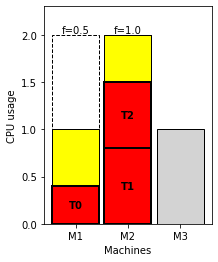

In [58]:
plot_online_dvfs_schedule(machines_info, tasks_info)

(<Figure size 144x288 with 1 Axes>,
 <AxesSubplot:xlabel='Machines', ylabel='CPU usage'>)

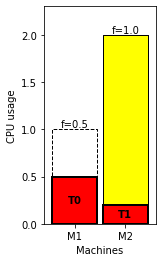

In [59]:
import math

configMachines = loadConfig('config_machines2.txt')
configTasks = loadConfig('config_tasks2.txt')

M = len(configMachines)
T = len(configTasks)
C = [float(configMachines[m][1]) for m in range(M)]
costs = [float(configTasks[j][2]) for j in range(T)]

machines_info2 = [{'capacity': C[m], 
                   'poweron': getProbVar(q6Prob, 'p'+str(m)).value(), 
                   'frequency': math.sqrt(getProbVar(q6Prob, 'f'+str(m)).value())} 
                  for m in range(M)]

tasks_info2 = []
for m in range(M):
    for j in range(T):
        if(getProbVar(q6Prob, 'x'+str(m)+'_'+str(j)).value() == 1):
            tasks_info2.append({'cpu': costs[j], 'machine': m})

plot_online_dvfs_schedule(machines_info2, tasks_info2)